In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
image_size = 28
num_classes = 10
num_epochs = 20
batch_size = 64 # 一个批次64张图片

In [3]:
train_dateset = datasets.MNIST(root='./data/hanwritten_digit/', train=True, transform=transforms.ToTensor(), download=True)
test_dateset = datasets.MNIST(root='./data/hanwritten_digit/', train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:44<00:00, 225kB/s] 


Extracting ./data/hanwritten_digit/MNIST/raw/train-images-idx3-ubyte.gz to ./data/hanwritten_digit/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 95.4kB/s]


Extracting ./data/hanwritten_digit/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/hanwritten_digit/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.18MB/s]


Extracting ./data/hanwritten_digit/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/hanwritten_digit/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 15.6MB/s]

Extracting ./data/hanwritten_digit/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/hanwritten_digit/MNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dateset, batch_size=batch_size, shuffle=True)

indices = range(len(test_dateset))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset=test_dateset, batch_size=batch_size, shuffle=False, sampler=sampler_val)
test_loader = torch.utils.data.DataLoader(dataset=test_dateset, batch_size=batch_size, shuffle=False, sampler=sampler_test)


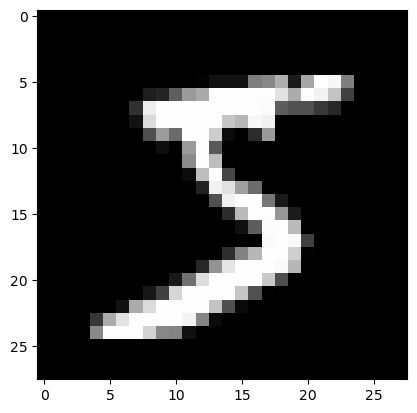

lable:  5


In [9]:
idx = 0

muteimg = train_dateset[idx][0].numpy()

plt.imshow(muteimg[0], cmap='gray')
plt.show()
print("lable: ", train_dateset[idx][1])

In [12]:
depth = [4, 8] # 两个卷积层的厚度
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, padding=2) # 输入通道1，输出通道4，卷积核5*5，padding=2
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding=2)
        
        self.fc1 = nn.Linear(image_size // 4 * image_size // 4 * depth[1], 512)
        
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x) # x的形状 [batch_size, 1, 28, 28]
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)  # x的形状 [batch_size, depth[1], 14, 14]
        x = self.pool(x) # x的形状 [batch_size, depth[1], 7, 7]
        
        x = x.view(-1, image_size // 4 * image_size // 4 * depth[1]) # x的形状 [batch_size, 7*7*depth[1]]
        
        x = F.relu(self.fc1(x))
        
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        x = F.log_softmax(x, dim=1)
        
        return x
        
    def retrieve_features(self, x):
        feature_map1 = F.relu(self.conv1(1))
        
        x = self.pool(feature_map1)
        
        feature_map2 = F.relu(self.conv2(x))
        
        return (feature_map1, feature_map2)